# Time Series Exercise - 

### Follow along with the instructions in bold. Watch the solutions video if you get stuck!

## The Data

** Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line **

**Monthly milk production: pounds per cow. Jan 62 - Dec 75**

** Import numpy pandas and matplotlib **

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

** Use pandas to read the csv of the monthly-milk-production.csv file and set index_col='Month' **

In [2]:
df = pd.read_csv('monthly-milk-production.csv', index_col='Month')

** Check out the head of the dataframe**

In [3]:
df.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


** Make the index a time series by using: **

    milk.index = pd.to_datetime(milk.index)

In [4]:
df.index = pd.to_datetime(df.index)

** Plot out the time series data. **

<AxesSubplot:xlabel='Month'>

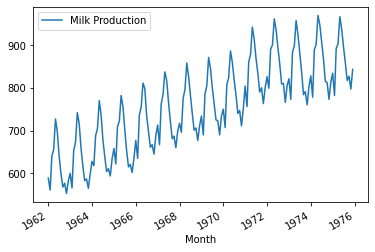

In [5]:
df.plot()

___

### Train Test Split

** Let's attempt to predict a year's worth of data. (12 months or 12 steps into the future) **

** Create a test train split using indexing (hint: use .head() or tail() or .iloc[]). We don't want a random train test split, we want to specify that the test set is the last 12 months of data is the test set, with everything before it is the training. **

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Milk Production  168 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


In [7]:
train_set = df.head(156)

In [8]:
test_set = df.tail(12)

### Scale the Data

** Use sklearn.preprocessing to scale the data using the MinMaxScaler. Remember to only fit_transform on the training data, then transform the test data. You shouldn't fit on the test data as well, otherwise you are assuming you would know about future behavior!**

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()

In [11]:
train_set = scaler.fit_transform(train_set)

In [12]:
test_set = scaler.transform(test_set)

## Batch Function

** We'll need a function that can feed batches of the training data. We'll need to do several things that are listed out as steps in the comments of the function. Remember to reference the previous batch method from the lecture for hints. Try to fill out the function template below, this is a pretty hard step, so feel free to reference the solutions! **

In [13]:
import numpy as np

In [14]:
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # STEP 1: Use np.random.randint to set a random starting point index for the batch.
    # Remember that each batch needs have the same number of steps in it.
    # This means you should limit the starting point to len(data)-steps
    start = np.random.randint(0, len(training_data) - steps)
    
    # STEP 2: Now that you have a starting index you'll need to index the data from
    # the random start to random start + steps + 1. Then reshape this data to be (1,steps+1)
    output = np.array(training_data[start: start + steps + 1]).reshape(1, steps + 1)
    
    # STEP 3: Return the batches. You'll have two batches to return y[:,:-1] and y[:,1:]
    # You'll need to reshape these into tensors for the RNN to .reshape(-1,steps,1)
    return output[:, :-1].reshape(-1, steps, 1), output[:,1:].reshape(-1, steps, 1)

## Setting Up The RNN Model

** Import TensorFlow **

In [15]:
import tensorflow as tf

### The Constants

** Define the constants in a single cell. You'll need the following (in parenthesis are the values I used in my solution, but you can play with some of these): **
* Number of Inputs (1)
* Number of Time Steps (12)
* Number of Neurons per Layer (100)
* Number of Outputs (1)
* Learning Rate (0.03)
* Number of Iterations for Training (4000)
* Batch Size (1)

In [16]:
inputs = 1
steps = 12
neurons = 100
outputs = 1
learning_rate = 0.03
iterations = 4000
batch_size = 1

** Create Placeholders for X and y. (You can change the variable names if you want). The shape for these placeholders should be [None,num_time_steps-1,num_inputs] and [None, num_time_steps-1, num_outputs] The reason we use num_time_steps-1 is because each of these will be one step shorter than the original time steps size, because we are training the RNN network to predict one point into the future based on the input sequence.**  

In [17]:
X = tf.placeholder(tf.float32, [None, steps, inputs])
y = tf.placeholder(tf.float32, [None, steps, outputs])

** Now create the RNN Layer, you have complete freedom over this, use tf.contrib.rnn and choose anything you want, OutputProjectionWrappers, BasicRNNCells, BasicLSTMCells, MultiRNNCell, GRUCell etc... Keep in mind not every combination will work well! (If in doubt, the solutions used an Outputprojection Wrapper around a basic LSTM cell with relu activation.**

In [18]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUCell(neurons, activation=tf.nn.relu), output_size=outputs)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.


** Now pass in the cells variable into tf.nn.dynamic_rnn, along with your first placeholder (X)**

In [19]:
outputs, state = tf.nn.dynamic_rnn(cell, inputs=X, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Loss Function and Optimizer

** Create a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer, remember to pass in your learning rate. **

In [20]:
mse = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
loss = optimizer.minimize(mse)

** Initialize the global variables **

In [21]:
init = tf.global_variables_initializer()

** Create an instance of tf.train.Saver() **

In [22]:
saver = tf.train.Saver()

### Session

** Run a tf.Session that trains on the batches created by your next_batch function. Also add an a loss evaluation for every 100 training iterations. Remember to save your model after you are done training. **

In [23]:
with tf.Session() as sess:
    # CODE HERE!
    sess.run(init)
    for i in range(iterations):
        x_data, y_data = next_batch(train_set, batch_size, steps)
        sess.run(loss, feed_dict={X:x_data, y:y_data})
        if i % 100 == 0:
            res = mse.eval(feed_dict={X:x_data, y:y_data})
            print(i, "\tMSE", res)
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

0 	MSE 0.24144548
100 	MSE 0.0077674645
200 	MSE 0.009590811
300 	MSE 0.008465804
400 	MSE 0.0061092437
500 	MSE 0.005478308
600 	MSE 0.0041851844
700 	MSE 0.0062718648
800 	MSE 0.008183813
900 	MSE 0.00544659
1000 	MSE 0.0060200747
1100 	MSE 0.0074088504
1200 	MSE 0.0047436412
1300 	MSE 0.011372008
1400 	MSE 0.0030206994
1500 	MSE 0.0054500797
1600 	MSE 0.004484668
1700 	MSE 0.0030548654
1800 	MSE 0.007090047
1900 	MSE 0.0023109233
2000 	MSE 0.003732359
2100 	MSE 0.0029622235
2200 	MSE 0.0034687072
2300 	MSE 0.014300051
2400 	MSE 0.004196761
2500 	MSE 0.0023446123
2600 	MSE 0.0036441146
2700 	MSE 0.0033297641
2800 	MSE 0.0016705574
2900 	MSE 0.004001198
3000 	MSE 0.0051121353
3100 	MSE 0.004785083
3200 	MSE 0.0023281388
3300 	MSE 0.004820323
3400 	MSE 0.005737107
3500 	MSE 0.0049919253
3600 	MSE 0.001752063
3700 	MSE 0.0014700308
3800 	MSE 0.003153161
3900 	MSE 0.002006173


______

## Predicting Future (Test Data)

** Show the test_set (the last 12 months of your original complete data set) **

In [24]:
# CODE HERE
test_set

array([[0.67548077],
       [0.55048077],
       [0.81490385],
       [0.84134615],
       [0.99278846],
       [0.92307692],
       [0.82451923],
       [0.73317308],
       [0.63461538],
       [0.65865385],
       [0.58653846],
       [0.69711538]])

In [25]:
preData = list(train_set[-12:])

** Now we want to attempt to predict these 12 months of data, using only the training data we had. To do this we will feed in a seed training_instance of the last 12 months of the training_set of data to predict 12 months into the future. Then we will be able to compare our generated 12 months to our actual true historical values from the test set! **

# Generative Session
### NOTE: Recall that our model is really only trained to predict 1 time step ahead, asking it to generate 12 steps is a big ask, and technically not what it was trained to do! Think of this more as generating new values based off some previous pattern, rather than trying to directly predict the future. You would need to go back to the original model and train the model to predict 12 time steps ahead to really get a higher accuracy on the test data. (Which has its limits due to the smaller size of our data set)
** Fill out the session code below to generate 12 months of data based off the last 12 months of data from the training set. The hardest part about this is adjusting the arrays with their shapes and sizes. Reference the lecture for hints.**

In [26]:

with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model")
    predicted_result = preData
    for i in range(12):
        input_batch = np.array(predicted_result[-steps:]).reshape(batch_size, steps, 1)
        y_pred = sess.run(outputs, feed_dict={X:input_batch})
        predicted_result.append(y_pred[0, -1, 0])

    # CODE HERE!

INFO:tensorflow:Restoring parameters from ./ex_time_series_model


/Users/limjunze/opt/anaconda3/envs/tfdeeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [27]:
predicted_result

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.66287565,
 0.5830548,
 0.8290212,
 0.8489702,
 0.9772072,
 0.92579556,
 0.8211502,
 0.72538114,
 0.63751465,
 0.6389582,
 0.60988593,
 0.6805192]

** Show the result of the predictions. **

** Grab the portion of the results that are the generated values and apply inverse_transform on them to turn them back into milk production value units (lbs per cow). Also reshape the results to be (12,1) so we can easily add them to the test_set dataframe.**

In [28]:
generatedData = np.array(predicted_result).reshape(-1, 1)[-12:]
predictedData = scaler.inverse_transform(generatedData)
predictedData

/Users/limjunze/opt/anaconda3/envs/tfdeeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([[828.75627136],
       [795.55078888],
       [897.87282562],
       [906.17159271],
       [959.51818848],
       [938.13095093],
       [894.59847641],
       [854.75855255],
       [818.20609474],
       [818.80661774],
       [806.7125473 ],
       [836.09599686]])

** Create a new column on the test_set called "Generated" and set it equal to the generated results. You may get a warning about this, feel free to ignore it.**

/Users/limjunze/opt/anaconda3/envs/tfdeeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='Month'>

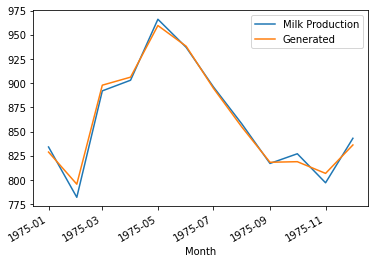

In [29]:
generatedDf = df.tail(12)
generatedDf['Generated'] = predictedData
generatedDf.plot()

In [30]:
generatedDf

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,828.756271
1975-02-01 01:00:00,782.0,795.550789
1975-03-01 01:00:00,892.0,897.872826
1975-04-01 01:00:00,903.0,906.171593
1975-05-01 01:00:00,966.0,959.518188
1975-06-01 01:00:00,937.0,938.130951
1975-07-01 01:00:00,896.0,894.598476
1975-08-01 01:00:00,858.0,854.758553
1975-09-01 01:00:00,817.0,818.206095


** View the test_set dataframe. **

** Plot out the two columns for comparison. **

# Great Job!

Play around with the parameters and RNN layers, does a faster learning rate with more steps improve the model? What about GRU or BasicRNN units? What if you train the original model to not just predict one timestep ahead into the future, but 3 instead? Lots of stuff to add on here!